##### Importing all libraries

In [129]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import numpy as NP
from math import sqrt
from numpy import sum

In [130]:
custom_colours = ['#74a09e','#98e2c6','#f2a553','#c14953']
SNS.set_theme(style="whitegrid",palette=custom_colours)

##### Loading the dataset

In [131]:
raw_data = PD.read_csv("50_Startups.csv", sep=";")
data = raw_data.copy()

##### Initial data exploration

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   R&D             50 non-null     float64
 1   Administration  50 non-null     float64
 2   Marketing       50 non-null     float64
 3   villes          50 non-null     object 
 4   Profit          50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.8+ KB


This dataset has **50** entries in **5** columns. It has **no missing data**. **4** columns are **numerical** and **1** column is **categorical**.

In [133]:
data.head()

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,Paris,192261.83
1,162597.70,151377.59,443898.53,Strasbourg,191792.06
2,153441.51,101145.55,407934.54,Lyon,191050.39
3,144372.41,118671.85,383199.62,Paris,182901.99
4,142107.34,91391.77,366168.42,Lyon,166187.94


Columns are ordered as follows:
- **3** columns detailing the **budget** each startup grants to each of their departments: **R&D**, **Administration** and **Marketing**.
- **1** column detailing the **location** where the startup supposedly operates from.
- **1** column detailing the **profit** each startup has made over an **unknown timespan**.

Paris         17
Strasbourg    17
Lyon          16
Name: villes, dtype: int64


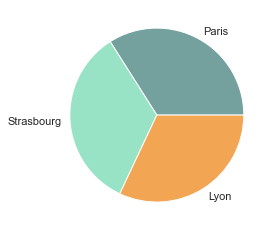

In [134]:
print(data["villes"].value_counts())
PLT.pie(data["villes"].value_counts(),labels=data["villes"].unique())
PLT.show()

We see here that we can order the dataset by the **'villes'** column since it is balanced around those values, with an even spread between all three of the cities found in that column : **Strasbourg**, **Paris** and **Lyon**.

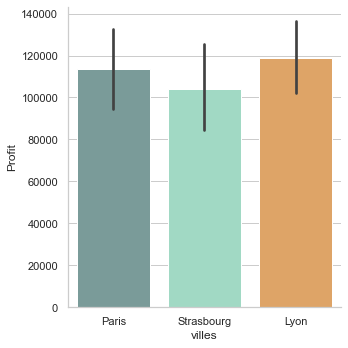

In [135]:
SNS.catplot(data=data,kind="bar",x="villes",y="Profit")
PLT.show()

We can see from this graph that, at face value, the "best" city to operate from is **Lyon** since it boasts both the highest **average profit** and **maximum profit**.

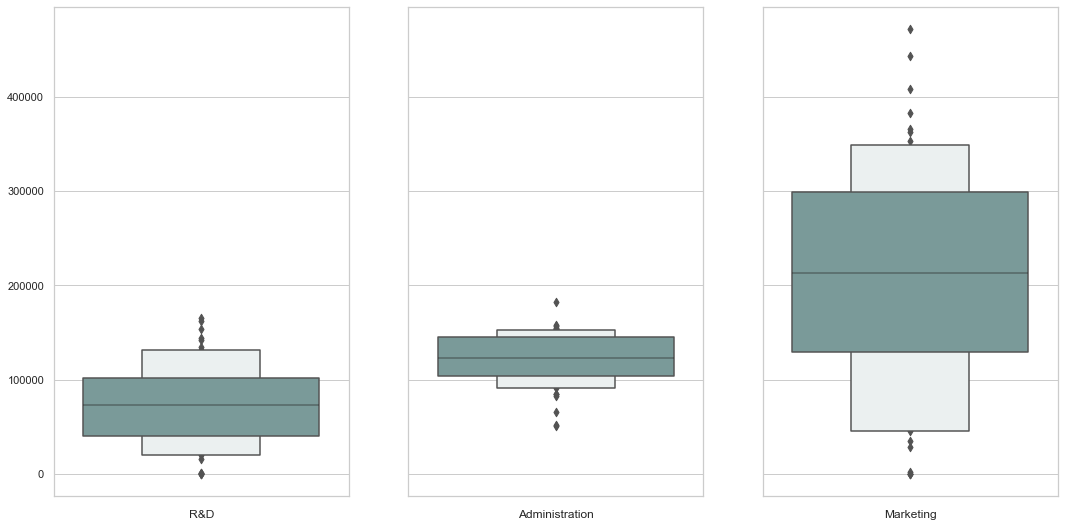

In [136]:
fig, ax = PLT.subplots(1,3,figsize=(18,9),sharey=True)
SNS.boxenplot(data=data,y="R&D",ax=ax[0])
ax[0].set_xlabel("R&D")
ax[0].set_ylabel("")
SNS.boxenplot(data=data,y="Administration",ax=ax[1])
ax[1].set_xlabel("Administration")
ax[1].set_ylabel("")
SNS.boxenplot(data=data,y="Marketing",ax=ax[2])
ax[2].set_xlabel("Marketing")
ax[2].set_ylabel("")
PLT.show()

By far, the highest budget allocation goes to the marketing department, it also demonstrates that there is a large variety of investment strategies for marketing whereas the budget for administration seems to have been figured out by most, as if they all shared a similar template; the same cannot be said for R&D but its overall budget remains the lowest across the board.

In [137]:
data.corr()

,R&D,Administration,Marketing,Profit
R&D,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


At first glance, we can see a strong correlation between R&D and Profit, a significant correlation between Marketing and Profit and almost none between Administration and Profit. This is not unexpected since the administration department cannot be expected to have as direct an impact on profit.

##### Plotting for each correlation

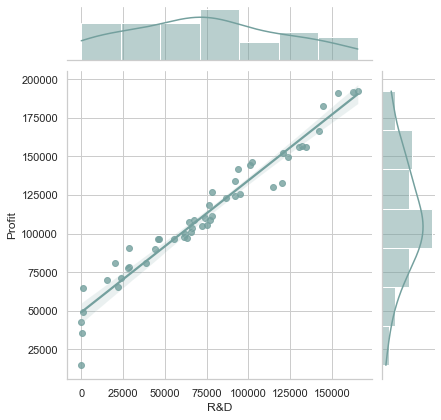

In [138]:
SNS.jointplot(x="R&D",y="Profit",kind="reg",data=data)
PLT.show()

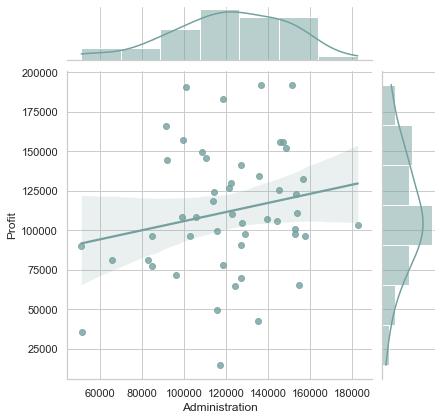

In [139]:
SNS.jointplot(x="Administration",y="Profit",kind="reg",data=data)
PLT.show()

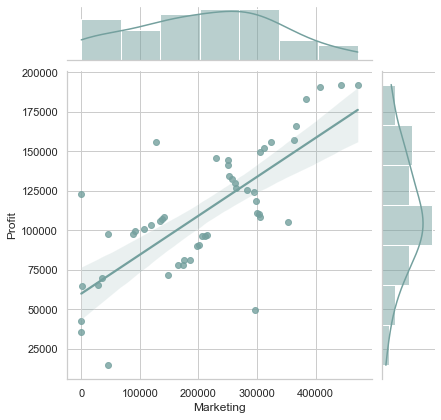

In [140]:
SNS.jointplot(x="Marketing",y="Profit",kind="reg",data=data)
PLT.show()

##### titre

In [141]:
data["Budget"] = data["R&D"]+data["Administration"]+data["Marketing"]
data.head()

,R&D,Administration,Marketing,villes,Profit,Budget
0,165349.20,136897.80,471784.10,Paris,192261.83,774031.10
1,162597.70,151377.59,443898.53,Strasbourg,191792.06,757873.82
2,153441.51,101145.55,407934.54,Lyon,191050.39,662521.60
3,144372.41,118671.85,383199.62,Paris,182901.99,646243.88
4,142107.34,91391.77,366168.42,Lyon,166187.94,599667.53


We decide to sum up all bugdets together in a new 'Budget' column to see the correlation between the overall budget of a startup and their profit. We expect a loss in precision in our model.

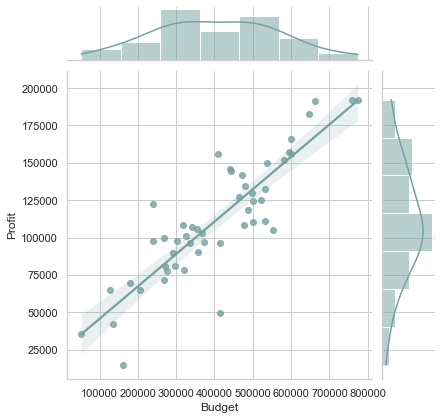

In [142]:
SNS.jointplot(x="Budget",y="Profit",kind="reg",data=data)
PLT.show()

Expectedly, the idea that you need to 'spend money to make money' seems to be holding true, with an almost normal distribution of our values.

##### titre

Importing all machine learning libraries

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, r2_score, max_error, mean_squared_error

Choosing our features and target

In [144]:
LR = LinearRegression()
X = data.loc[:,data.columns != 'Profit'].copy()
X.drop("villes",axis=1,inplace=True)
y = data['Profit'].copy()

Creating the training and testing datasets

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=666)

Training and scoring the Linear Regression model

In [146]:
def R2_AdjR2(y,f,nb_features):
    p = nb_features
    n = len(y)
    SSres = 0
    for i in range(n):
        ei = y[i] - f[i]
        SSres += ei**2
    y_ = (1/n)*sum(y)
    SStot = 0
    for i in range(n):
        SStot += (y[i]-y_)**2
    R2 = 1 - (SSres/SStot)
    dfe = n-p-1
    dft = n-1
    adj_R2 = 1 - (SSres/dfe)/(SStot/dft) # adj_R2 = 1 - (1-R2)*(n-1)/(n-p-1)
    return R2, adj_R2

In [147]:
LR.fit(X_train,y_train)
predictions = LR.predict(X_test)
res_df = PD.DataFrame(dict(R_et_D=X_test["R&D"],Administration=X_test['Administration'],Marketing=X_test['Marketing'], Budget=X_test['Budget'],y_true=y_test,y_pred=predictions))
print(f"Explained Variance Score = {explained_variance_score(y_test,predictions)}")
print(f"Max Error = {max_error(y_test,predictions)}")
print("Coefficients: ", LR.coef_)
print("Mean unsquared error: %.2f" % sqrt(mean_squared_error(y_test, predictions)))
print("Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
Y = NP.array(y_test)
f = NP.array(predictions)
R2, adj_R2 = R2_AdjR2(Y,f,4)
print(f"R Squared = {R2}")
print(f"adjusted R Squared = {adj_R2}")

Explained Variance Score = 0.928929087837613
Max Error = 41542.128000000004
Coefficients:  [ 3.63333911e+12  3.63333911e+12  3.63333911e+12 -3.63333911e+12]
Mean unsquared error: 14797.76
Mean squared error: 218973616.89
R Squared = 0.9265769591357829
adjusted R Squared = 0.8972077427900961


- Explained Variance Regression Score: *[0, 1]*
    - With a score of **.93**, our model has close to no deviation.
- Max Error: *[0, +∞]*
    - With a score of **41542**
- Coefficients:
    - 
- Mean Squared Error:
- R Squared: 

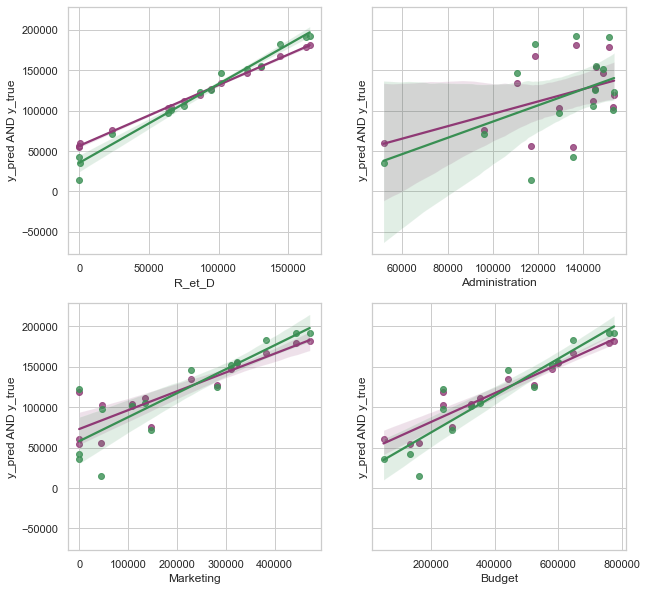

In [148]:
fig, ax = PLT.subplots(2,2,figsize=(10,10), sharey=True)
SNS.regplot(x="R_et_D",y="y_pred",data=res_df, ax=ax[0,0], color="#8F3975")
SNS.regplot(x="R_et_D",y="y_true",data=res_df, ax=ax[0,0], color="#398F53")
ax[0,0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Administration",y="y_pred",data=res_df, ax=ax[0,1], color="#8F3975")
SNS.regplot(x="Administration",y="y_true",data=res_df, ax=ax[0,1], color="#398F53")
ax[0,1].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Marketing",y="y_pred",data=res_df, ax=ax[1,0], color="#8F3975")
SNS.regplot(x="Marketing",y="y_true",data=res_df, ax=ax[1,0], color="#398F53") 
ax[1,0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Budget",y="y_pred",data=res_df, ax=ax[1,1], color="#8F3975")
SNS.regplot(x="Budget",y="y_true",data=res_df, ax=ax[1,1], color="#398F53")
ax[1,1].set_ylabel("y_pred AND y_true")
PLT.show()

In [149]:
from sklearn.feature_selection import f_regression
f_statistic, p_values = f_regression(X,y)
print(f"F values = {f_statistic}")
print(f"P values = {p_values}")

F values = [849.7889044    2.01495972  60.88145448 153.19616857]
P values = [3.50032224e-32 1.62217395e-01 4.38107318e-10 1.50826749e-16]


In [150]:
LR_A = LinearRegression()
Xa = X.drop(columns=["Administration"])
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa,y,test_size=.3,random_state=666)
LR_A.fit(Xa_train,ya_train)
A_predictions = LR_A.predict(Xa_test)
print(f"Explained Variance Score = {explained_variance_score(ya_test, A_predictions)}")
print(f"Max Error = {max_error(ya_test, A_predictions)}")
print("Coefficients: ", LR_A.coef_)
print("Mean squared error: %.2f" % mean_squared_error(ya_test, A_predictions))
Y = NP.array(ya_test)
f = NP.array(A_predictions)
R2, adj_R2 = R2_AdjR2(Y,f,3)
print(f"R Squared = {R2}")
print(f"adjusted R Squared = {adj_R2}")

Explained Variance Score = 0.9304730465291711
Max Error = 41557.60905081056
Coefficients:  [ 0.8243257   0.07337703 -0.06678468]
Mean squared error: 215873403.42
R Squared = 0.9276164775194323
adjusted R Squared = 0.9078755168429139


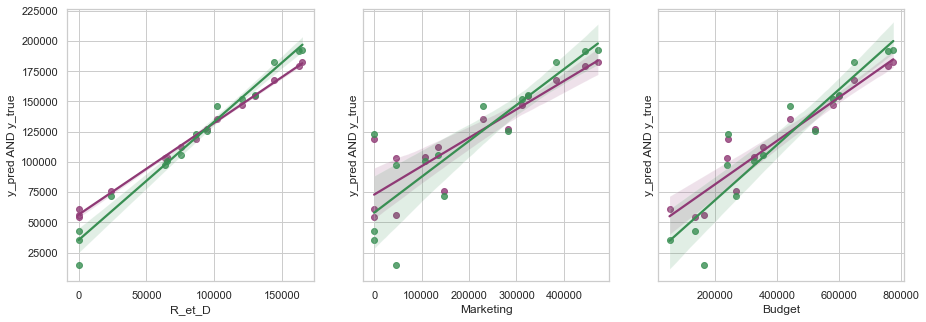

In [151]:
res_df_A = PD.DataFrame(dict(R_et_D=Xa_test["R&D"],Marketing=Xa_test['Marketing'], Budget=Xa_test['Budget'],y_true=ya_test,y_pred=A_predictions))
fig, ax = PLT.subplots(1,3,figsize=(15,5), sharey=True)
SNS.regplot(x="R_et_D",y="y_pred",data=res_df_A, ax=ax[0], color="#8F3975")
SNS.regplot(x="R_et_D",y="y_true",data=res_df_A, ax=ax[0], color="#398F53")
ax[0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Marketing",y="y_pred",data=res_df_A, ax=ax[1], color="#8F3975")
SNS.regplot(x="Marketing",y="y_true",data=res_df_A, ax=ax[1], color="#398F53")
ax[1].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Budget",y="y_pred",data=res_df_A, ax=ax[2], color="#8F3975")
SNS.regplot(x="Budget",y="y_true",data=res_df_A, ax=ax[2], color="#398F53") 
ax[2].set_ylabel("y_pred AND y_true")

PLT.show()

In [152]:
f_statistic, p_values = f_regression(Xa,y)
print(f"F values = {f_statistic}")
print(f"P values = {p_values}")

F values = [849.7889044   60.88145448 153.19616857]
P values = [3.50032224e-32 4.38107318e-10 1.50826749e-16]
